# Task -1 Anomaly detection
## Student ID1: *********
## Student ID2:

In [ ]:
%pip install oletools

In [352]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy import stats
import warnings
pd.set_option('display.float_format', lambda x: '%.2' % x)


ModuleNotFoundError: No module named 'sklearn'

## Read the data

In [11]:
# file path - this for linux windows you will need "//"
f_path = "conn_attack.csv"
'''
record ID - The unique identifier for each connection record.
duration_  This feature denotes the number of seconds (rounded) of the connection. For example, a connection for 0.17s or 0.3s would be indicated with a “0” in this field.
src_bytes This field represents the number of data bytes transferred from the source to the destination (i.e., the amount of out-going bytes from the host).
dst_bytes This fea
ture represents the number of data bytes transferred from the destination to the source (i.e., the amount of bytes received by the host).
'''
df = pd.read_csv(f_path,names=["record ID","duration_", "src_bytes","dst_bytes"], header=None)

In [ ]:
# drops nan values in the dataset
df

Checks for missing data

In [17]:
# calculates the missing data precentage
df.apply(lambda x: sum(x.isna()) / len(df))


record ID    0.0
duration_    0.0
src_bytes    0.0
dst_bytes    0.0
dtype: float64

Result: No data is missing

In [18]:
df.shape # gets details about the num of rows and columns of our dataset 

(256670, 4)

## Data Overview & Exploration

In [23]:
df.head() # checks how our dataset looks like

,record ID,duration_,src_bytes,dst_bytes
0,1,0,236,1228
1,2,0,239,486
2,3,0,234,1364
3,4,0,239,1295
4,5,0,181,5450


*Data fields*
* record ID - The unique identifier for each connection record.
* Duration_ - This feature denotes the number of seconds (rounded) of the connection. For
example, a connection for 0.17s or 0.3s would be indicated with a “0” in this field.
* src_bytes - This field represents the number of data bytes transferred from the source to the
destination (i.e., the number of outgoing bytes from the host).
* dst_bytes - This feature represents the number of data bytes transferred from the destination
to the source (i.e., the number of bytes received by the host).

In [312]:
df.describe() # general statistics about the dataset

,record ID,duration_,src_bytes,dst_bytes
count,256670.000000,256670.000000,256670.000000,2.566700e+05
mean,128335.500000,0.640936,474.247898,4.473533e+03
std,74094.391134,15.627170,3391.106084,2.080903e+04
min,1.000000,0.000000,0.000000,0.000000e+00
25%,64168.250000,0.000000,217.000000,6.600000e+02
50%,128335.500000,0.000000,249.000000,1.661000e+03
75%,192502.750000,0.000000,306.000000,4.341000e+03
max,256670.000000,3289.000000,54540.000000,7.068759e+06


Dataset statistics calculations

In [325]:
df.agg(
    {
        "duration_": ["min", "max", "median", "mean", "skew"],
        "src_bytes": ["min", "max", "median", "mean", "skew"],
        "dst_bytes": ["min", "max", "median", "mean", "skew"],

    }
)

,duration_,src_bytes,dst_bytes
min,0.00,0.00,0.00
max,3289.00,54540.00,7068759.00
median,0.00,249.00,1661.00
mean,0.64,474.25,4473.53
skew,74.03,15.82,207.10


In [338]:
# caluculates and stores the median and the std of each feature 

median_duration = df['duration_'].median()
print(f"median_duration: {median_duration:.2f}")

std_duration = df['duration_'].std()
print(f"std_duration: {std_duration:.2f}")

median_src_b = df['src_bytes'].median()
print(f"median_src_b: {median_src_b:.2f}")

std_src_b = df['src_bytes'].std()
print(f"std_src_b: {std_src_b:.2f}")

median_dst_b = df['dst_bytes'].mean()
print(f"median_dst_b: {median_dst_b:.2f}")

std_dst_b = df['dst_bytes'].std()
print(f"std_dst_b: {std_dst_b:.2f}")

total_smaples = df.count()
print(f"total_smaples: {total_smaples[0]}")

median_duration: 0.00
std_duration: 15.63
median_src_b: 249.00
std_src_b: 3391.11
median_dst_b: 4473.53
std_dst_b: 20809.03
total_smaples: 256670


In [362]:
# calculates the suspected share of outliers in the dataset
contamination = df[df['src_bytes'] > (median_src_b + std_dst_b)].count() / total_smaples
print(f"The contamination is: {contamination[0]:.08f}")
# calculates the percentage of samples in which the data sent exceeded its mean + std
percentage = df[df['src_bytes'] > (median_src_b + std_dst_b)].count() / total_smaples * 100
print(f"The percentage of samples in which the data sent exceeded its mean + std is: {percentage[0]:.08f}%")
df[df['src_bytes'] > (median_src_b + std_dst_b)]

The contamination is: 0.00395060
The percentage of samples in which the data sent exceeded its mean + std is: 0.39505980%


,record ID,duration_,src_bytes,dst_bytes
140814,140815,0,54540,8314
140815,140816,0,54540,8314
140816,140817,0,54540,8314
140817,140818,0,54540,8314
140818,140819,0,54540,8314
...,...,...,...,...
232764,232765,0,54540,8314
232765,232766,0,54540,8314
232766,232767,0,54540,8314
232767,232768,0,54540,8314


In [348]:
df[df['src_bytes'] > (median_src_b + std_dst_b)].describe() # let's describe our results

,record ID,duration_,src_bytes,dst_bytes
count,1014.00,1014.00,1014.00,1014.00
mean,150139.82,0.14,54254.08,8206.33
std,24259.63,1.22,2101.76,695.78
min,140815.00,0.00,26280.00,0.00
25%,141069.25,0.00,54540.00,8314.00
50%,143045.50,0.00,54540.00,8314.00
75%,143299.75,0.00,54540.00,8314.00
max,232769.00,14.00,54540.00,8315.00


In [369]:
'''
Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.
'''
#skewness and kurtosis
print("Skewness: %f" % df['src_bytes'].skew())
print("Kurtosis: %f" % df['src_bytes'].kurt()) # positive show long tail , negative light tail

Skewness: 15.824471
Kurtosis: 248.739606


Skewness: 207.100418
Kurtosis: 61028.785029


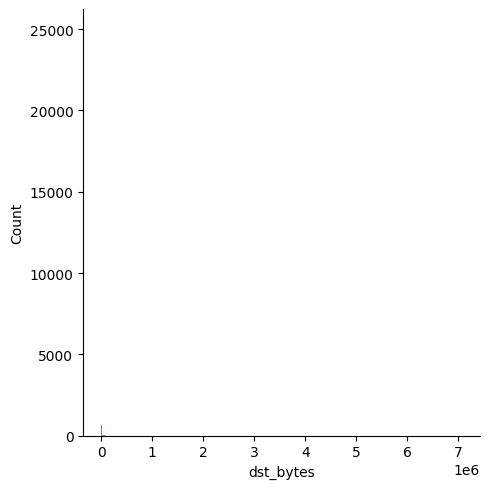

In [371]:
sns.displot(df['dst_bytes'])
print("Skewness: %f" % df['dst_bytes'].skew())
print("Kurtosis: %f" % df['dst_bytes'].kurt())

<AxesSubplot:xlabel='dst_bytes', ylabel='src_bytes'>

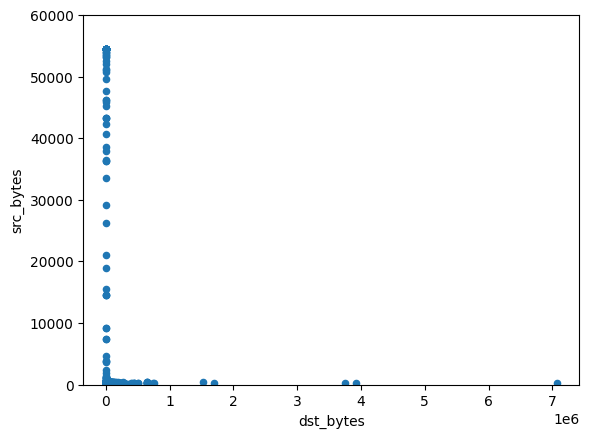

In [376]:
# relationship with numerical variables
var = 'dst_bytes'
data = pd.concat([df['src_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='src_bytes', ylim=(0,60000))

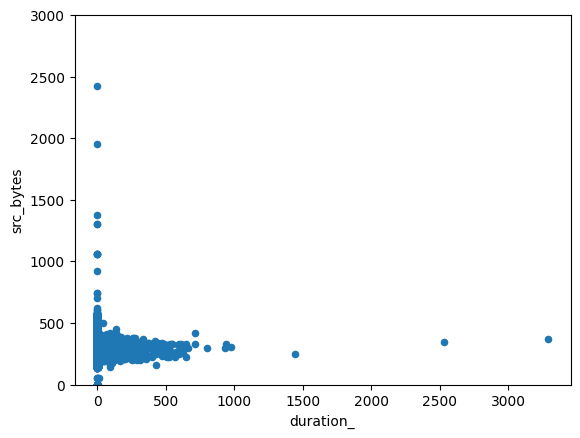

In [380]:
#scatter plot totalbsmtsf/saleprice
var = 'duration_'
data = pd.concat([df['src_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='src_bytes', ylim=(0,3000));


Correlation is a statistical term which in common usage refers to how close two variables are to having a linear relationship with each other.

In [381]:
df.corr() 

,record ID,duration_,src_bytes,dst_bytes
record ID,1.00,0.03,0.02,-0.00
duration_,0.03,1.00,-0.00,-0.01
src_bytes,0.02,-0.00,1.00,0.01
dst_bytes,-0.00,-0.01,0.01,1.00


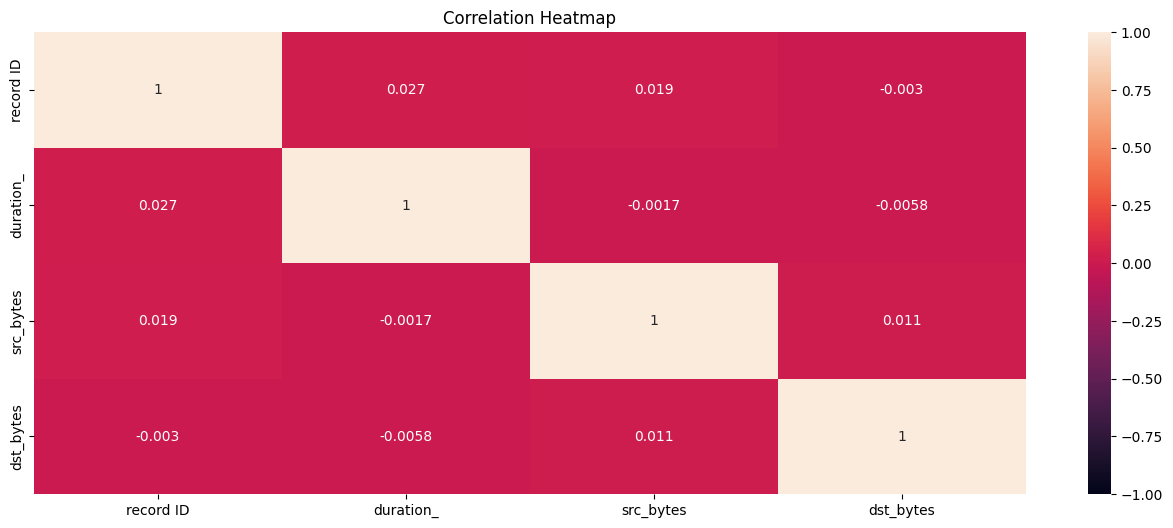

In [382]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

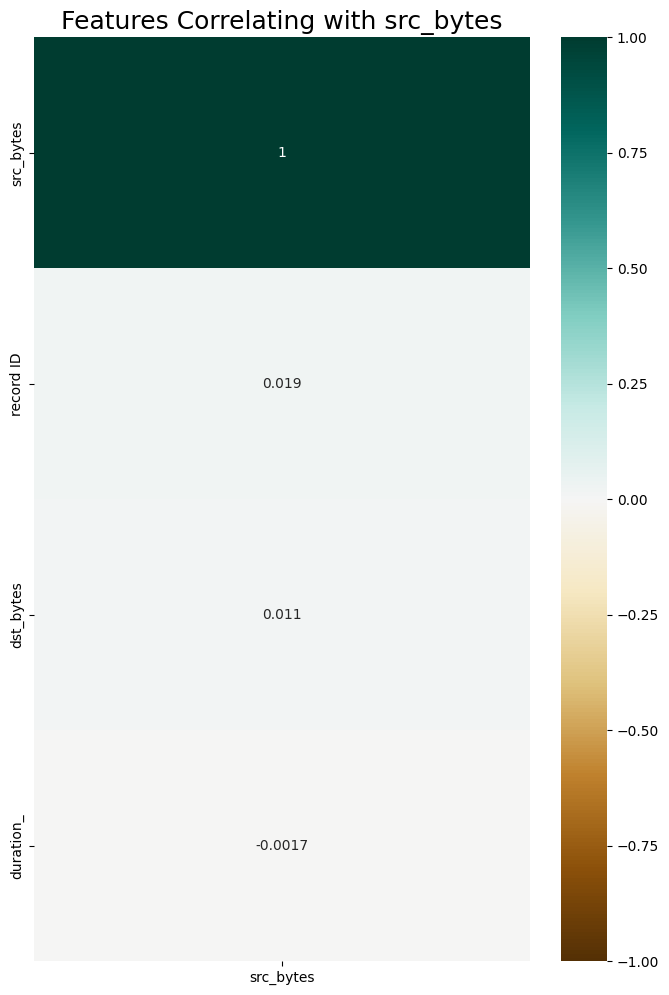

In [383]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['src_bytes']].sort_values(by='src_bytes', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with src_bytes', fontdict={'fontsize':18});

# Back to the task

Summary of data exploration:

    Did this help you?
    What did you find?
    What the data exploration tell you about the data and the possible attacks?

# Machine Learning Algorithms

### Algorithm: Isolation Forest

In [ ]:
# calculates the suspected share of outliers in the dataset
contamination = df[df['src_bytes'] > (median_src_b + std_dst_b)].count() / total_smaples
n_estimators = 50
data = df[["duration_", "src_bytes","dst_bytes"]]

# trains the model 
model = IsolationForest(contamination = contamination, n_estimators = n_estimators)
model.fit(data)

In [ ]:
# predicts
df["is_anomaly?_"] = pd.Series(model.predict(data))
# maps the predictions from 1->0 and from -1->1
df["is_anomaly?_"] = df["is_anomaly?_"].map({1:0, -1:1})

In [ ]:
# counts the number of anomalies that we got
anomaly = df["is_anomaly?_"].value_counts()[1]
print(anomaly)

# Summary and results

# Create the final submission results

In [ ]:
'''
What to submit?

record ID - The unique identifier for each connection record.
is_anomaly?_  This binary field indicates your detection result: 0 denotes the transmission is normal, 1 indicates anomalous.
Summary Report

'''